In [18]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from plotnine import *
from sklearn.model_selection import GridSearchCV

In [4]:
# Read the data
ames = pd.read_csv("AmesHousing.csv")

# Get rid of columns with mostly NaN values
good_cols = ames.isna().sum() < 100
ames = ames.loc[:,good_cols]

# Drop other NAs
ames = ames.dropna()

Make a pipeline that uses all the variables in the Ames dataset, and then fits Ridge Regression with λ = 1.

Cross-validate this pipeline and compare the results to the ordinary linear regression.

Then fit the model on the whole dataset and get the coefficients. Make a plot of these coefficients compared to the ones from ordinary linear regression.

In [35]:
X = ames.drop(["SalePrice", "Order", "PID"], axis = 1)
y = ames["SalePrice"]

ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

lr_pipeline = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
)

ridge_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("ridge_regression", Ridge(alpha=1.0))
    ]
)

linreg_cv_scores = cross_val_score(lr_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
ridge_cv_scores = cross_val_score(ridge_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')

print("Ridge Regression MSE:", -ridge_cv_scores.mean())
print("Linear Regression MSE:", -linreg_cv_scores.mean())

Ridge Regression MSE: 878606253.1364206
Linear Regression MSE: 5.166881943860257e+30


In [36]:
ridge_pipeline.fit(X, y)
lr_pipeline.fit(X, y)

ridge_coeff = ridge_pipeline.named_steps["ridge_regression"].coef_
linreg_coeff = lr_pipeline.named_steps["linear_regression"].coef_

all_feature_names = ct.get_feature_names_out()

df = pd.DataFrame({
    "Feature": all_feature_names,
    "Ridge": ridge_coeff,
    "Linear": linreg_coeff
})

df.head()

,Feature,Ridge,Linear
0,dummify__MS Zoning_C (all),-5585.147073,-2.241800e+13
1,dummify__MS Zoning_FV,1279.599730,-2.241800e+13
2,dummify__MS Zoning_I (all),-5465.717759,-2.241800e+13
3,dummify__MS Zoning_RH,7876.141644,-2.241800e+13
4,dummify__MS Zoning_RL,3046.095382,-2.241800e+13


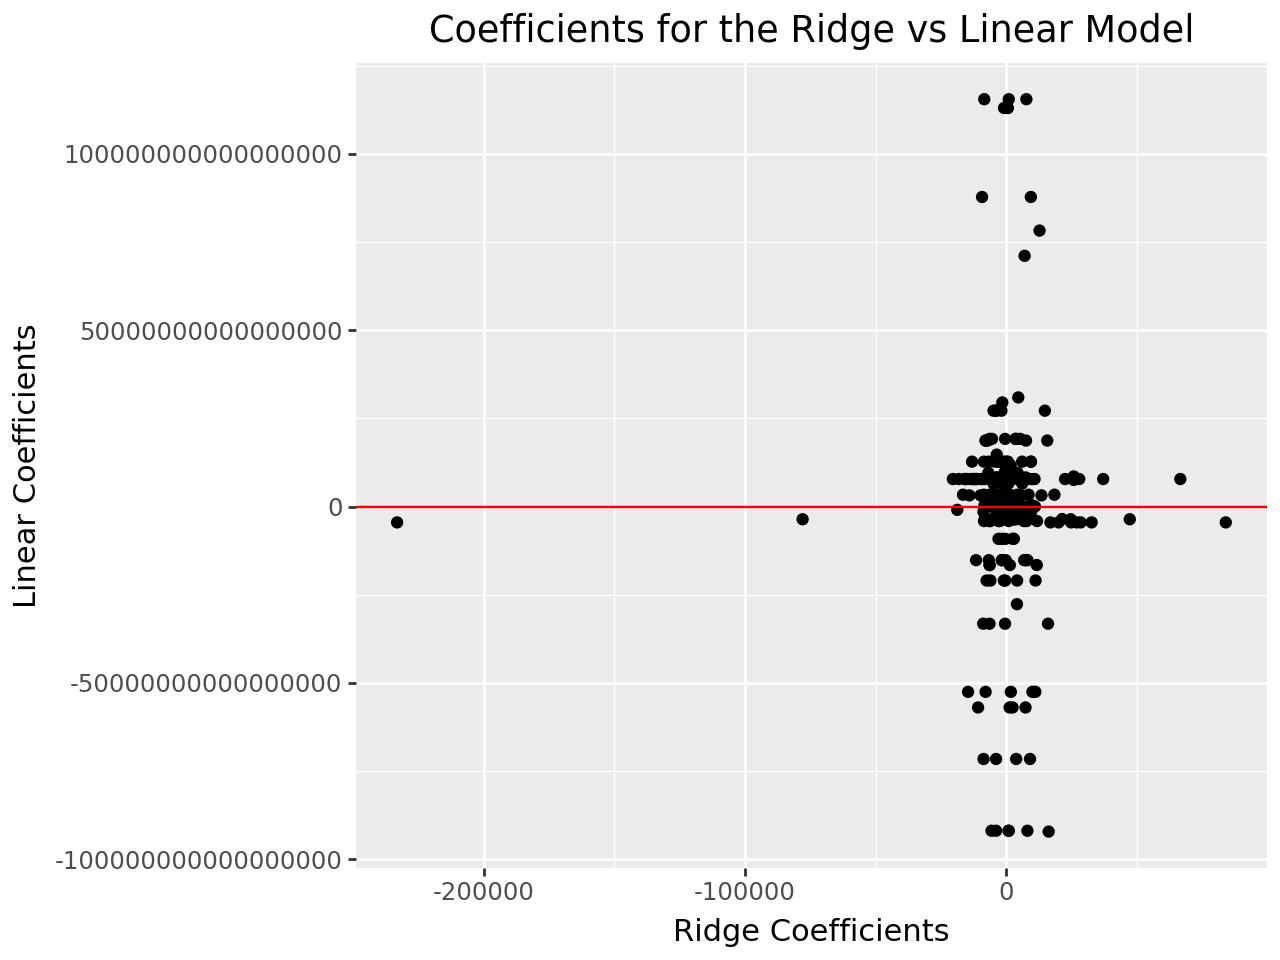

In [17]:
(ggplot(df, aes(x ='Ridge', y='Linear')) +
   geom_point() +
   geom_abline(slope=1, intercept=0, color='red') +
   labs(title = "Coefficients for the Ridge vs Linear Model",
           x= "Ridge Coefficients",
           y= 'Linear Coefficients'))

After cross-validating both models, Ridge Regression has a much lower mean squared error (MSE) than Linear Regression. This is because Ridge Regression applies a penalty to large coefficients, reducing overfitting by limiting the impact of less important predictors. In the coefficient plot, Ridge’s coefficients are more concentrated around zero, showing the effect of regularization, while Linear Regression’s coefficients are spread out more widely. This regularization helps Ridge Regression achieve more stable predictions by controlling the variability often seen in unpenalized linear models.

Using the same pipeline as previously, perform tuning on λ.

You should always try λ
 values on a log scale; that is, don’t use [1,2,3,4]; instead use something like [0.001, 0.01, 0.1, 1, 10]

In [20]:
param_grid = {
    "ridge_regression__alpha": [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

grid_search = GridSearchCV(
    estimator=ridge_pipeline,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=5,
    verbose=1
)

grid_search.fit(X, y)

pd.DataFrame(grid_search.cv_results_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ridge_regression__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.101514,0.027258,0.040412,0.009498,0.001,{'ridge_regression__alpha': 0.001},-7.879837e+08,-5.055365e+08,-1.232594e+09,-1.558419e+09,-5.521019e+08,-9.273271e+08,4.073286e+08,6
1,0.119559,0.059321,0.028423,0.008122,0.010,{'ridge_regression__alpha': 0.01},-7.875414e+08,-5.043629e+08,-1.231952e+09,-1.555683e+09,-5.490131e+08,-9.257105e+08,4.072283e+08,5
2,0.109300,0.040356,0.031833,0.009522,0.100,{'ridge_regression__alpha': 0.1},-7.844687e+08,-4.948191e+08,-1.226204e+09,-1.533577e+09,-5.252551e+08,-9.128649e+08,4.061908e+08,4
3,0.147910,0.061738,0.032071,0.008546,1.000,{'ridge_regression__alpha': 1},-7.812889e+08,-4.658465e+08,-1.198009e+09,-1.468869e+09,-4.790183e+08,-8.786063e+08,3.974769e+08,2
4,0.128025,0.052309,0.038390,0.011617,10.000,{'ridge_regression__alpha': 10},-7.843267e+08,-4.468206e+08,-1.165080e+09,-1.455916e+09,-4.723607e+08,-8.649009e+08,3.936439e+08,1
5,0.176091,0.072500,0.028584,0.002554,100.000,{'ridge_regression__alpha': 100},-8.610209e+08,-4.402347e+08,-1.206868e+09,-1.558299e+09,-4.809330e+08,-9.094712e+08,4.279248e+08,3
6,0.128195,0.062978,0.028681,0.002842,1000.000,{'ridge_regression__alpha': 1000},-1.134543e+09,-5.779050e+08,-1.264095e+09,-1.725513e+09,-6.446800e+08,-1.069347e+09,4.229867e+08,7


The table shows that the best value for λ is 10.

Create a LASSO pipeline, and tune λ.

Fit your best model on the full Ames data, and compare the coefficients to Ridge and OLS.

In [23]:
lasso_pipeline = Pipeline(
    [
        ("preprocessing", ct),
        ("lasso_regression", Lasso())
    ]
)

param_grid = {
    "lasso_regression__alpha": [0.01, 0.1, 1, 10, 100]
}

grid_search_lasso = GridSearchCV(
    estimator=lasso_pipeline,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=5,
    verbose=1
)

grid_search_lasso.fit(X, y)

pd.DataFrame(grid_search_lasso.cv_results_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.110e+11, tolerance: 1.348e+09
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.466e+11, tolerance: 1.474e+09
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.988e+11, tolerance: 1.463e+09
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.p

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lasso_regression__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.551853,0.922516,0.045958,0.034386,0.01,{'lasso_regression__alpha': 0.01},-7.885959e+08,-5.055637e+08,-1.221825e+09,-1.545230e+09,-5.257282e+08,-9.173885e+08,4.065590e+08,5
1,0.777371,0.105549,0.029280,0.003689,0.10,{'lasso_regression__alpha': 0.1},-7.881923e+08,-5.052834e+08,-1.192081e+09,-1.545152e+09,-5.265207e+08,-9.114459e+08,4.021607e+08,4
2,0.684658,0.097854,0.027617,0.002832,1.00,{'lasso_regression__alpha': 1},-7.844667e+08,-5.025365e+08,-1.186430e+09,-1.543847e+09,-5.235216e+08,-9.081603e+08,4.023206e+08,3
3,0.823741,0.569587,0.048944,0.015859,10.00,{'lasso_regression__alpha': 10},-7.612077e+08,-4.792376e+08,-1.160131e+09,-1.527524e+09,-5.048793e+08,-8.865960e+08,4.032322e+08,2
4,0.282898,0.014963,0.027434,0.001939,100.00,{'lasso_regression__alpha': 100},-7.533482e+08,-4.263880e+08,-1.136937e+09,-1.480770e+09,-4.475923e+08,-8.490071e+08,4.076566e+08,1


The table shows that the best value for λ is 100.

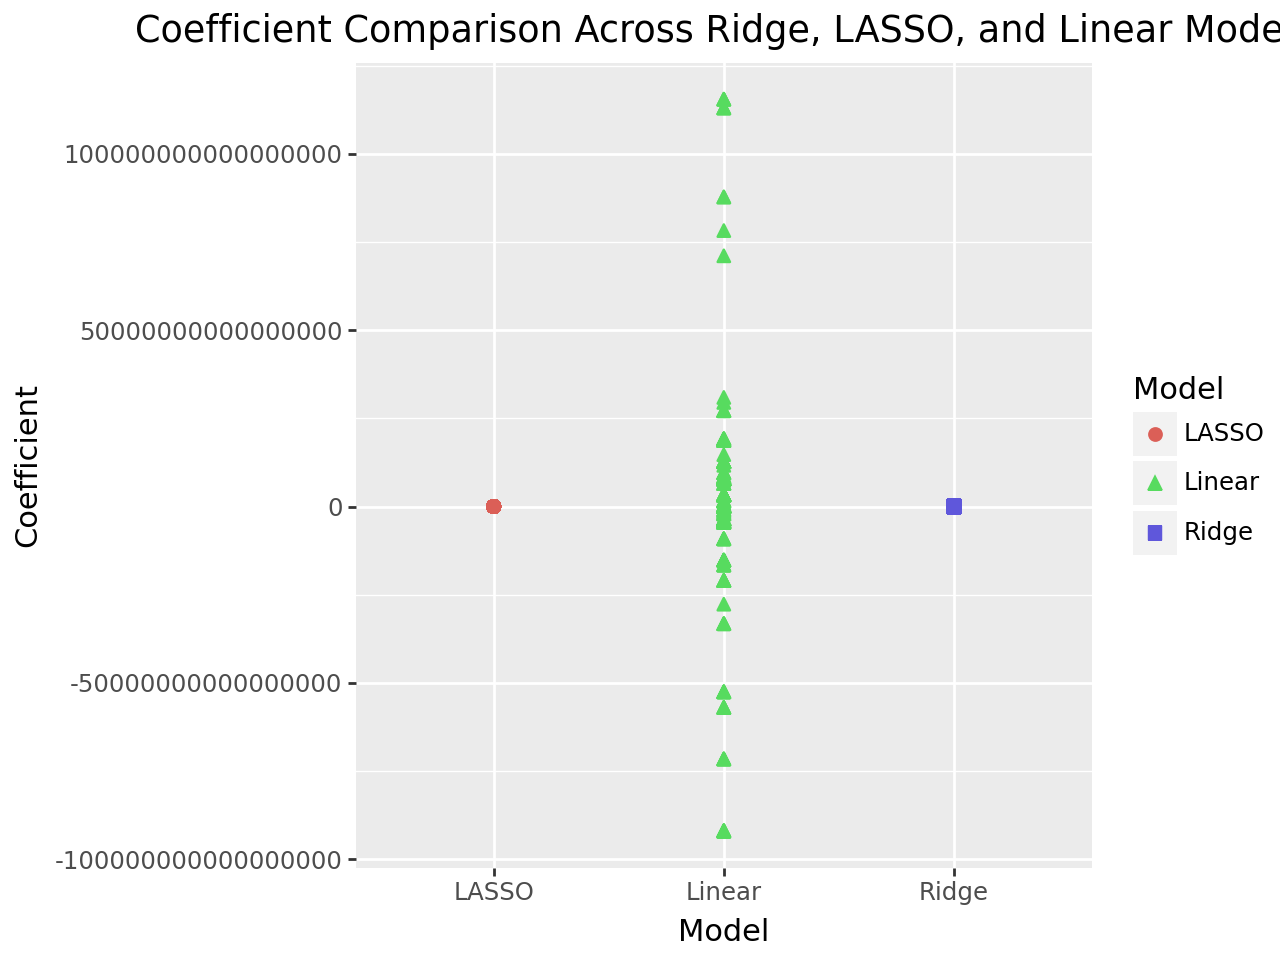

In [32]:
best_lasso = grid_search_lasso.best_estimator_.named_steps["lasso_regression"].coef_

# Add LASSO coefficients to the existing DataFrame
df["LASSO"] = best_lasso

# Melt the DataFrame for plotting
df_long = pd.melt(df, id_vars="Feature", value_vars=["Ridge", "Linear", "LASSO"],
                  var_name="Model", value_name="Coefficient")

(ggplot(df_long, aes(x='Model', y='Coefficient', color='Model')) +
    geom_point(aes(shape='Model'), size=2) +
    labs(title="Coefficient Comparison Across Ridge, LASSO, and Linear Models",
         x="Model",
         y="Coefficient")
)

LASSO pushes many coefficients close to zero, effectively removing less important features from the model. Ridge also reduces the size of coefficients but keeps them non-zero, which helps control overfitting while retaining all features. The Linear model, with no regularization, has very large and varied coefficients, indicating possible overfitting.

Create an Elastic Net pipeline, and tune λ and α.

Fit your best model on the full Ames data, and compare the coefficients to Ridge and OLS.

Fitting 5 folds for each of 12 candidates, totalling 60 fits


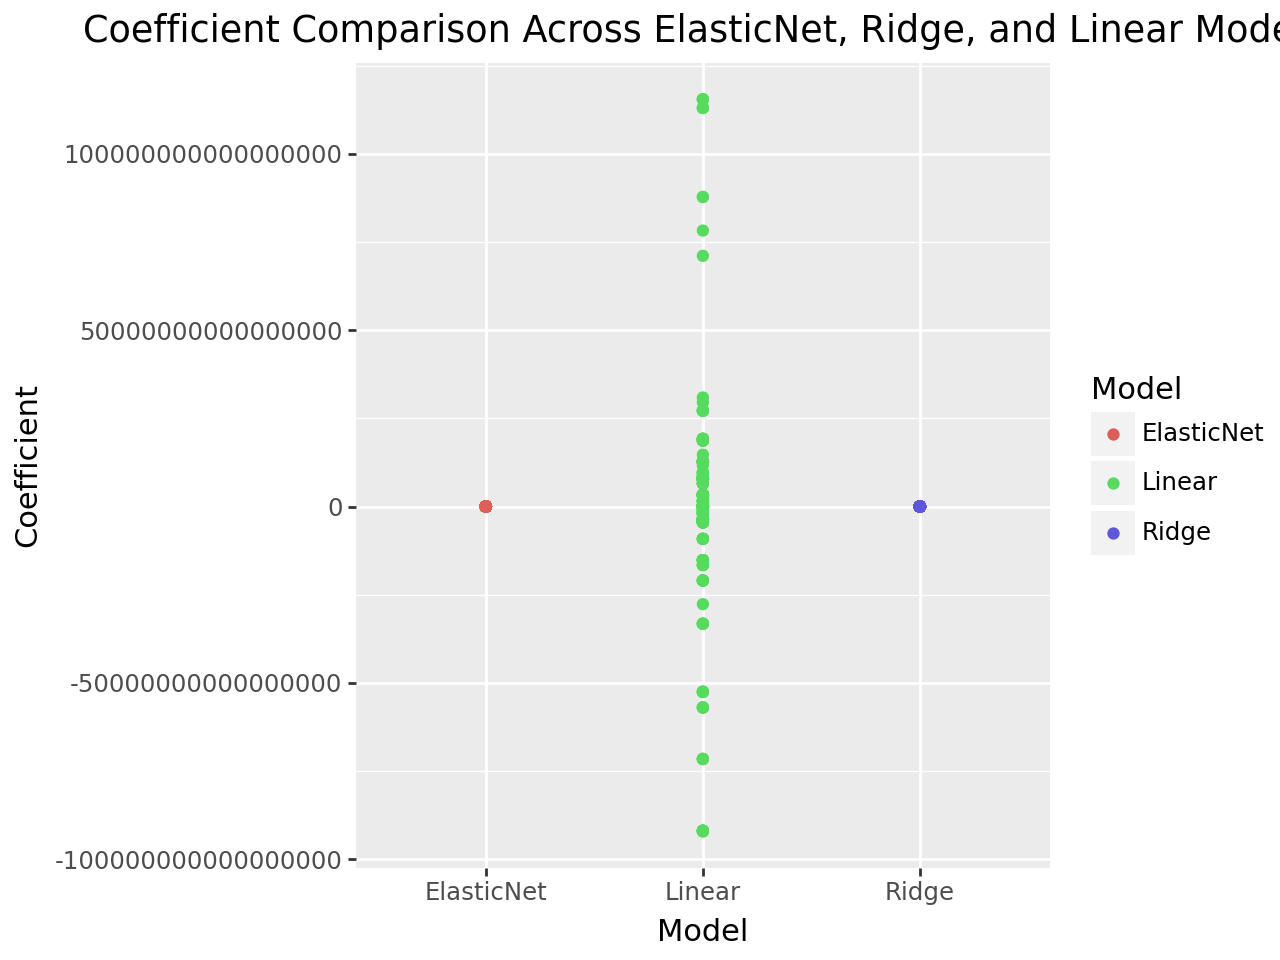

In [39]:
# ElasticNet pipeline
elastic_net_pipeline = Pipeline(
    [
    ("preprocessing", ct),
    ("elastic_net", ElasticNet())
    ]
)

param_grid = {
    "elastic_net__alpha": [ 0.1, 1, 10, 100],
    "elastic_net__l1_ratio": [0.2, 0.5, 0.8]
}

# Set up GridSearchCV with cross-validation
grid_search_elastic_net = GridSearchCV(
    estimator=elastic_net_pipeline,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=5,
    verbose=1
)

# Fit the model
grid_search_elastic = grid_search_elastic_net.fit(X, y)

# Best Elastic Net model
best_elastic_net = grid_search_elastic.best_estimator_

# Get coefficients
elastic_net_coeff = best_elastic_net.named_steps["elastic_net"].coef_
ridge_coeff = ridge_pipeline.named_steps["ridge_regression"].coef_
ols_coeff = lr_pipeline.named_steps["linear_regression"].coef_

# Combine coefficients into a DataFrame for plotting
all_feature_names = ct.get_feature_names_out()
coefficients_df = pd.DataFrame({
    "Feature": all_feature_names,
    "ElasticNet": elastic_net_coeff,
    "Ridge": ridge_coeff,
    "Linear": ols_coeff
})

# Reshape DataFrame for plotting with plotnine
coefficients_long = coefficients_df.melt(id_vars="Feature", var_name="Model", value_name="Coefficient")

(ggplot(coefficients_long, aes(x="Model", y="Coefficient", color="Model")) +
 geom_point() +
 labs(title="Coefficient Comparison Across ElasticNet, Ridge, and Linear Models",
      x="Model",
      y="Coefficient"))